# Deep Learning with keras

**This kernel is a *Keras Based* solution for toxicity classification. **

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['train.csv', 'sample_submission.csv', 'test.csv']


In [2]:
import sys, os, re, csv, codecs, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D, Conv1D, MaxPool1D, GRU
from tensorflow.keras import backend
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers

**Loading the CSVs** 

In [3]:
#Class labels
'''list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

#Read the data
toxicWordsTrain = pd.read_csv("../input/train.csv");
toxicWordsTest = pd.read_csv("../input/test.csv")

y_train = toxicWordsTrain[list_classes].values
x_train = toxicWordsTrain["comment_text"]
x_test  = toxicWordsTest["comment_text"]

submission = pd.read_csv('../input/sample_submission.csv')'''
#train=pd.read_csv('train.csv').iloc[:700]
train = pd.read_csv("../input/train.csv")
test = pd.read_csv("../input/test.csv")
#test=pd.read_csv('test.csv').iloc[:700]

### EDA

Total comments falling in perticular class label :-  [15294, 1595, 8449, 478, 7877, 1405]


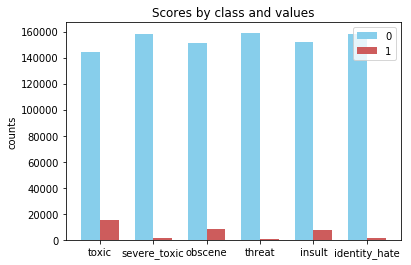

In [4]:
v={}
for i in train.columns[2:]:
    #print(train[i].value_counts())
    values=train[i].value_counts()
    v[i]={0:values[0],1:values[1]}

list_0_count,list_1_count=[],[]
for i in (list(v.values())):
    list_0_count.append(list(i.values())[0])
    list_1_count.append(list(i.values())[1])
#print('Total comments not falling in perticular per class label :- ',list_0_count)
print('Total comments falling in perticular class label :- ',list_1_count)


ind = np.arange(len(v.keys()))  # the x locations for the groups
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(ind - width/2, list_0_count, width, 
                color='SkyBlue', label='0')
rects2 = ax.bar(ind + width/2, list_1_count, width, 
                color='IndianRed', label='1')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('counts')
ax.set_title('Scores by class and values')
ax.set_xticks(ind)
ax.set_xticklabels(v.keys())
ax.legend()
plt.show()

### Class proportionality with respect to each other

{'toxic': 15294, 'severe_toxic': 1595, 'obscene': 8449, 'threat': 478, 'insult': 7877, 'identity_hate': 1405}


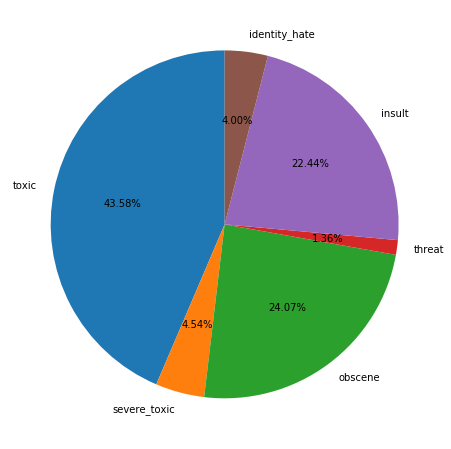

In [5]:
size={}
for i in train.columns[2:]:
    size[i]=(train[i]==1).sum()
print(size)
'''for i in train.columns[2:]:
    values=train[i].unique()
    print(values)'''
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
plt.pie(size.values(),labels=size.keys(), autopct='%.2f%%',startangle=90)
plt.axis('off')
#plt.legend()
plt.show()


### Class proportionality with respect to each other with hist

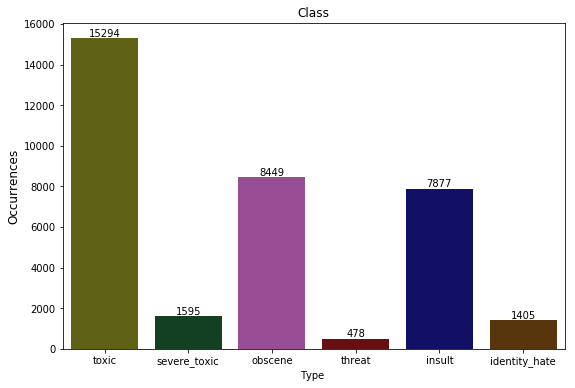

None

In [6]:
import seaborn as sns
colors_list = ["brownish green", "pine green", "ugly purple",
               "blood", "deep blue", "brown", "azure"]

palette= sns.xkcd_palette(colors_list)

x=train.iloc[:,2:].sum()
#print(x.index)
plt.figure(figsize=(9,6))
ax= sns.barplot(x.index, x.values,palette=palette)
plt.title("Class")
plt.ylabel('Occurrences', fontsize=12)
plt.xlabel('Type ')
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 10, label, 
            ha='center', va='bottom')
display(plt.show())


**Overview for brief view over Comment Length** 

 mean_length:  394.0732213246768 
 standard_length:  590.7202819048923 
 max_length:  5000


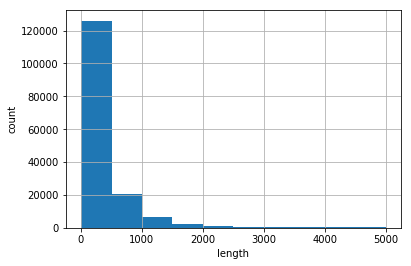

In [7]:
lens = train.comment_text.str.len()
print(' mean_length: ',lens.mean(),'\n standard_length: ',lens.std(),'\n max_length: ',lens.max())
plt.xlabel('length')
plt.ylabel('count')
lens.hist();


**Set some basic config parameters to pass to keras model:**

In [8]:
MAX_FEATURES = 60000
MAX_TEXT_LENGTH = 1000
BATCH_SIZE = 32
EPOCHS = 10
VALIDATION_SPLIT = 0.1
CLASSES_LIST = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]


### Tokenizing
**Missing values are filled with a sample string and then the comment text is tokenized *from tensorflow->keras->preprocessing->text import 'Tokenizer'*.**

In [9]:

train_raw_text = train["comment_text"].fillna("MISSINGVALUE").values
test_raw_text = test["comment_text"].fillna("MISSINGVALUE").values
tokenizer = Tokenizer(num_words=MAX_FEATURES)

tokenizer.fit_on_texts(list(train_raw_text))
train_tokenized = tokenizer.texts_to_sequences(train_raw_text)
test_tokenized = tokenizer.texts_to_sequences(test_raw_text)
x_train,x_test= pad_sequences(train_tokenized, maxlen=MAX_TEXT_LENGTH),pad_sequences(test_tokenized, maxlen=MAX_TEXT_LENGTH)

y = train[CLASSES_LIST].values
#print(y[:100])
print (len(x_train), len(x_test))

159571 153164


## Deep Learning model building with 10 layered model

In [10]:
embed_size = 300
inp = Input(shape=(MAX_TEXT_LENGTH,))
model = Embedding(MAX_FEATURES, embed_size)(inp)
model = Dropout(0.2)(model)
model = Conv1D(filters=32, kernel_size=2, padding='same', activation='relu')(model)
model = MaxPool1D(pool_size=2)(model)
model = Conv1D(filters=32, kernel_size=2, padding='same', activation='relu')(model)
model = MaxPool1D(pool_size=2)(model)
model = GRU(128)(model)
model = Dense(64, activation="relu")(model)
model = Dense(32, activation="relu")(model)
model = Dense(16, activation="relu")(model)
model = Dense(6, activation="sigmoid")(model)
model = Model(inputs=inp, outputs=model)
model.compile(loss='binary_crossentropy', optimizer='adagrad', metrics=['accuracy'])
model.summary()
    

model.fit(x_train, y, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=1, validation_split=VALIDATION_SPLIT)

#model.load_weights(MODEL_FILE_PATH)

#y_test = train_fit_predict(get_model(), x_train, x_test, y)


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1000)              0         
_________________________________________________________________
embedding (Embedding)        (None, 1000, 300)         18000000  
_________________________________________________________________
dropout (Dropout)            (None, 1000, 300)         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 1000, 32)          19232     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 500, 32)           0         
_________________________________________________________________
conv1d_1 (Conv1D)    

**Predicting the output for test data**

In [11]:
y_test=model.predict(x_test, batch_size=BATCH_SIZE, verbose=1)

153164/153164 [==============================] - 904s 6ms/sample


In [12]:
#y_train_test=model.predict(x_train, batch_size=BATCH_SIZE, verbose=1)


In [13]:
#print(y_train_test[:10])
'''
print(new_train_test.head())
'''
y_test=pd.DataFrame(y_test)
print(y_test.head())


          0             1    ...                4         5
0  0.997849  3.882785e-01    ...     9.804615e-01  0.236261
1  0.000006  0.000000e+00    ...     5.960464e-08  0.000003
2  0.000121  1.788139e-07    ...     2.384186e-06  0.000028
3  0.000005  0.000000e+00    ...     0.000000e+00  0.000002
4  0.000006  0.000000e+00    ...     8.940697e-08  0.000002

[5 rows x 6 columns]


**Converting linear output values to binary 0 & 1**

In [14]:
df = np.where(y_test >= 0.5, 1, 0)
final=pd.DataFrame(df)
print(new_y_test.head())

NameError: name 'new_y_test' is not defined

In [15]:
#print(y[6])
#print(y[12])
print(final.shape)
print(test['id'].shape)

(153164, 6)
(153164,)


#### Creating the submission file

In [16]:
#y_test=pd.DataFrame(y_test)

y_test=pd.DataFrame(data={'id':test['id'],CLASSES_LIST[0]:final.iloc[:,0],
                          CLASSES_LIST[1]:final.iloc[:,1],
                          CLASSES_LIST[2]:final.iloc[:,2], 
                          CLASSES_LIST[3]:final.iloc[:,3],
                          CLASSES_LIST[4]:final.iloc[:,4], 
                          CLASSES_LIST[5]:final.iloc[:,5]})
y_test.to_csv('submit.csv',index=False)

